In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

# os.chdir('..')
os.getcwd()

'/Users/rohaan/Desktop/storage/RIT/federated_learning_lab/federated_learning'

In [4]:
jsons = os.listdir('save/LeNet5')
jsons.sort()
jsons

['updates_epoch_1.json', 'updates_epoch_2.json', 'updates_epoch_3.json']

In [5]:
updates = []
for update in jsons:
    with open('save/LeNet5/' + update, 'r') as f:
       epoch_updates = json.load(f)
       updates.append(epoch_updates)
       
len(updates)

3

In [6]:
len(updates[0])

10

In [7]:
type(updates[0])

dict

In [8]:
updates[0].keys()

dict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [9]:
def flatten_params(params):
    param_vector = np.concatenate([np.array(v).flatten() for v in params.values()])
    return param_vector

In [10]:
df = pd.DataFrame()

for i in range(len(updates)):
    param_updates = flatten_params(updates[i])
    col_name = f'round_{i+1}'
    df[col_name] = param_updates
    
df.head()

,round_1,round_2,round_3
0,0.196348,0.245986,-0.040151
1,0.215569,0.126095,-0.037012
2,-0.073096,-0.101417,-0.123235
3,-0.574383,-0.273805,-0.231978
4,-0.560934,-0.022090,-0.062973


In [11]:
len(df.round_1) == 61706

True

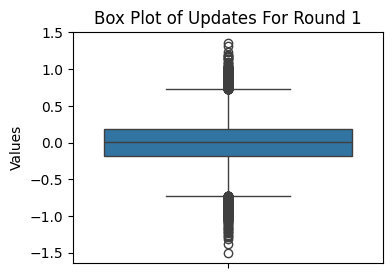

In [12]:
plt.figure(figsize=(4, 3))
sns.boxplot(y=df['round_1'])
plt.title('Box Plot of Updates For Round 1')
plt.ylabel('Values')
plt.show()

In [13]:
df_melted = df.melt(var_name='Column', value_name='Value')

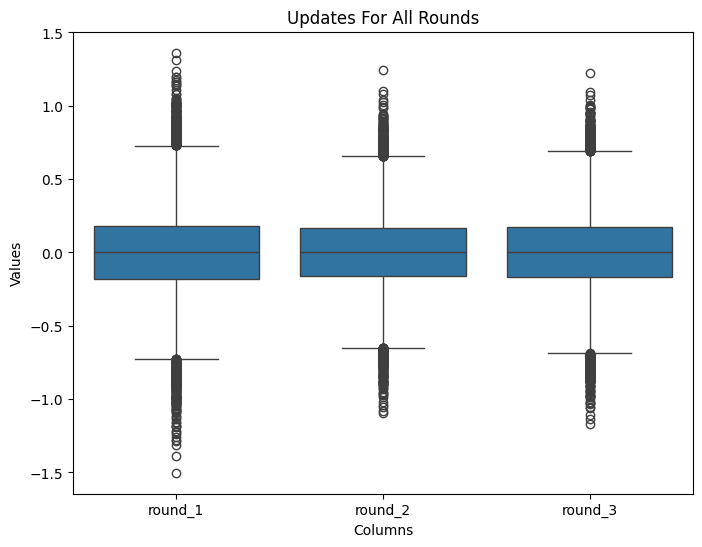

In [14]:
# Plot box plots for each column
plt.figure(figsize=(8, 6))
sns.boxplot(x='Column', y='Value', data=df_melted)
plt.title('Updates For All Rounds')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

In [15]:
class GA:
    def __init__(self, 
                 seed : int, 
                 d : int, 
                 q : int) -> None:
        self.seed = seed
        self.d = d 
        self.q = q
        
    def G(self):
        np.random.seed(self.seed)
        return np.random.rand(self.d, self.q)
    
    def w (self, delta):
        GT = self.G().transpose()
        return np.dot(GT, delta)/(self.q)
    
    def delta(self, w):
        return np.dot(self.G(), w)

In [17]:
import random

for i, col in enumerate(df.columns):
    new_col = f'reconstructed_{col}'
    seed = random.randint(0, 100)
    ga = GA(seed=seed,
            d=len(df),
            q=100)
    w = ga.w(df[col].to_numpy())
    df[new_col] = ga.delta(w)
    
df

,round_1,round_2,round_3,reconstructed_round_1,reconstructed_round_2,reconstructed_round_3
0,0.196348,0.245986,-0.040151,1.519210,7.105090,24.466521
1,0.215569,0.126095,-0.037012,1.330521,7.021781,23.913181
2,-0.073096,-0.101417,-0.123235,2.223535,7.799270,26.988347
3,-0.574383,-0.273805,-0.231978,1.555924,6.325505,27.587222
4,-0.560934,-0.022090,-0.062973,1.419910,6.088051,22.641598
...,...,...,...,...,...,...
61701,-0.169674,-0.091538,-0.366016,0.125735,7.616223,26.703083
61702,0.422995,0.113344,0.086249,0.495241,6.611005,29.615873
61703,-0.232639,-0.098551,-0.116813,0.949884,6.765673,24.844901
61704,0.101197,-0.021558,0.025157,1.137278,6.504416,25.234200


In [18]:
# Melt the dataframe
df_melted = df.melt(var_name='Column', value_name='Value')

# Create the keyword flag based on the melted dataframe
keyword = "reconstructed"
df_melted['Keyword_Flag'] = df_melted['Column'].apply(lambda x: keyword in x)

# custom palette based on the keyword flag
palette = {True: '#F76902', # RIT Orange
           False: '#4c72b0' # Seaborn Deep  Blue
           }

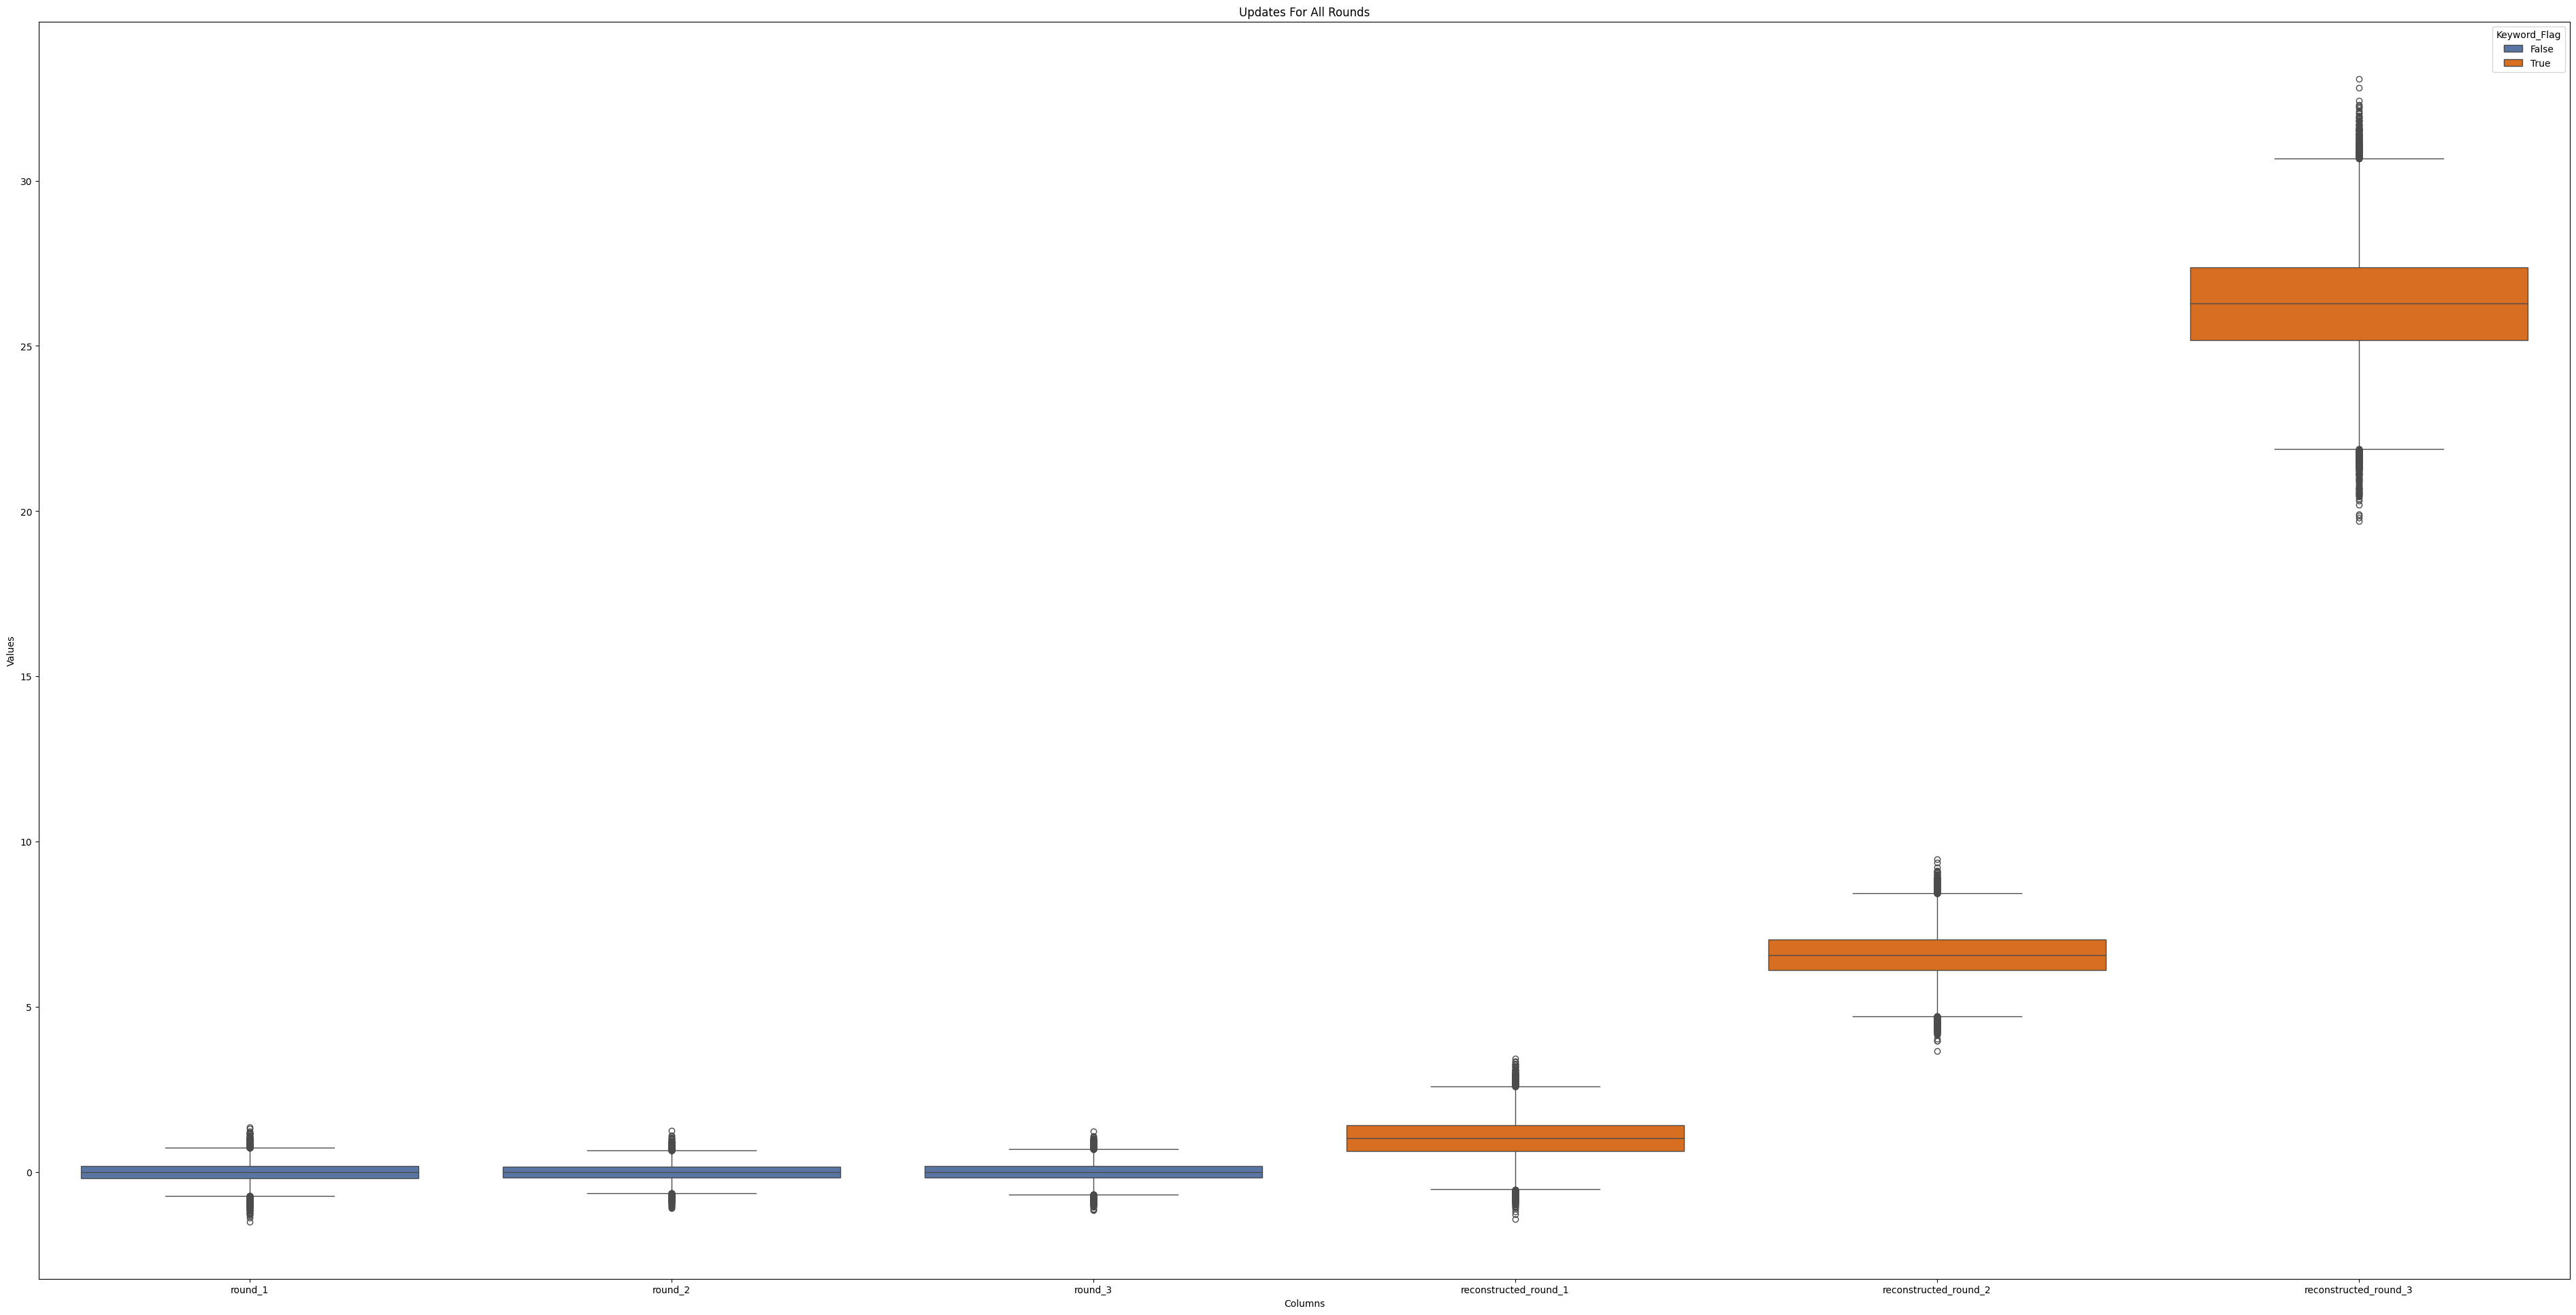

In [19]:
plt.figure(figsize=(48, 24))
sns.boxplot(x='Column', y='Value', hue='Keyword_Flag', data=df_melted, palette=palette)
plt.title('Updates For All Rounds')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

In [20]:
for col in df.columns:
    print(f'col={col}, mean={df[col].mean()}, median={df[col].median()}')

col=round_1, mean=2.2378178000898636e-05, median=0.0007290858775377274
col=round_2, mean=0.0004689742967605495, median=0.0011679613962769508
col=round_3, mean=0.001606847737935797, median=0.0016023069620132446
col=reconstructed_round_1, mean=1.027241662326166, median=1.0273614973881355
col=reconstructed_round_2, mean=6.572493867526198, median=6.569952367448815
col=reconstructed_round_3, mean=26.27173635261688, median=26.2778088273395


In [21]:
df.describe()

,round_1,round_2,round_3,reconstructed_round_1,reconstructed_round_2,reconstructed_round_3
count,61706.000000,61706.000000,61706.000000,61706.000000,61706.000000,61706.000000
mean,0.000022,0.000469,0.001607,1.027242,6.572494,26.271736
std,0.278795,0.245935,0.262077,0.577886,0.686533,1.625775
min,-1.501025,-1.094554,-1.166826,-1.417288,3.666837,19.687631
25%,-0.182314,-0.162882,-0.171104,0.638643,6.107664,25.176192
50%,0.000729,0.001168,0.001602,1.027361,6.569952,26.277809
75%,0.181730,0.164285,0.174040,1.419003,7.036002,27.372203
max,1.361503,1.245117,1.224550,3.433106,9.458975,33.088195


In [22]:
print('real_delta_1 : reconstructed_delta_1 =', (df.round_1.max()-df.round_1.min())/(df.reconstructed_round_1.max()-df.reconstructed_round_1.min()))

real_delta_1 : reconstructed_delta_1 = 0.5901639109414409


In [27]:
print('real_delta_2 : reconstructed_delta_2 =', (df.round_2.max()-df.round_2.min())/(df.reconstructed_round_2.max()-df.reconstructed_round_2.min()))

real_delta_2 : reconstructed_delta_2 = 0.4039390813850008


In [28]:
print('real_delta_3 : reconstructed_delta_3 =', (df.round_3.max()-df.round_3.min())/(df.reconstructed_round_3.max()-df.reconstructed_round_3.min()))

real_delta_3 : reconstructed_delta_3 = 0.1784533664299565


In [30]:
for col in ['reconstructed_round_1', 'reconstructed_round_2', 'reconstructed_round_3']:
    min_value = df[col].min()
    max_value = df[col].max()
    
    new_col = 'normalized_' + col
    df[new_col] = (df[col] - min_value)/(max_value - min_value)
    
df

,round_1,round_2,round_3,reconstructed_round_1,reconstructed_round_2,reconstructed_round_3,normalized_reconstructed_round_1,normalized_reconstructed_round_2,normalized_reconstructed_round_3
0,0.196348,0.245986,-0.040151,1.519210,7.105090,24.466521,0.605414,0.593607,0.356619
1,0.215569,0.126095,-0.037012,1.330521,7.021781,23.913181,0.566512,0.579224,0.315326
2,-0.073096,-0.101417,-0.123235,2.223535,7.799270,26.988347,0.750624,0.713456,0.544807
3,-0.574383,-0.273805,-0.231978,1.555924,6.325505,27.587222,0.612984,0.459013,0.589497
4,-0.560934,-0.022090,-0.062973,1.419910,6.088051,22.641598,0.584942,0.418017,0.220436
...,...,...,...,...,...,...,...,...,...
61701,-0.169674,-0.091538,-0.366016,0.125735,7.616223,26.703083,0.318123,0.681853,0.523519
61702,0.422995,0.113344,0.086249,0.495241,6.611005,29.615873,0.394304,0.508304,0.740882
61703,-0.232639,-0.098551,-0.116813,0.949884,6.765673,24.844901,0.488037,0.535007,0.384855
61704,0.101197,-0.021558,0.025157,1.137278,6.504416,25.234200,0.526672,0.489902,0.413906


In [31]:
for round in [1,2,3]:
    new_col = f'round_{round}_star'
    min_value = df[f'round_{round}'].min()
    difference = df[f'round_{round}'].max() - min_value
    df[new_col] = (df[f'normalized_reconstructed_round_{round}'] * difference) + min_value
    
df

,round_1,round_2,round_3,reconstructed_round_1,reconstructed_round_2,reconstructed_round_3,normalized_reconstructed_round_1,normalized_reconstructed_round_2,normalized_reconstructed_round_3,round_1_star,round_2_star,round_3_star
0,0.196348,0.245986,-0.040151,1.519210,7.105090,24.466521,0.605414,0.593607,0.356619,0.231990,0.294291,-0.314017
1,0.215569,0.126095,-0.037012,1.330521,7.021781,23.913181,0.566512,0.579224,0.315326,0.120633,0.260639,-0.412762
2,-0.073096,-0.101417,-0.123235,2.223535,7.799270,26.988347,0.750624,0.713456,0.544807,0.647658,0.574698,0.136011
3,-0.574383,-0.273805,-0.231978,1.555924,6.325505,27.587222,0.612984,0.459013,0.589497,0.253658,-0.020614,0.242882
4,-0.560934,-0.022090,-0.062973,1.419910,6.088051,22.641598,0.584942,0.418017,0.220436,0.173387,-0.116531,-0.639681
...,...,...,...,...,...,...,...,...,...,...,...,...
61701,-0.169674,-0.091538,-0.366016,0.125735,7.616223,26.703083,0.318123,0.681853,0.523519,-0.590388,0.500758,0.085105
61702,0.422995,0.113344,0.086249,0.495241,6.611005,29.615873,0.394304,0.508304,0.740882,-0.372319,0.094711,0.604902
61703,-0.232639,-0.098551,-0.116813,0.949884,6.765673,24.844901,0.488037,0.535007,0.384855,-0.104005,0.157188,-0.246494
61704,0.101197,-0.021558,0.025157,1.137278,6.504416,25.234200,0.526672,0.489902,0.413906,0.006588,0.051656,-0.177022


In [32]:
df_2 = df[['round_1', 'round_2', 'round_3', 'round_1_star', 'round_2_star', 'round_3_star']]
df_2

,round_1,round_2,round_3,round_1_star,round_2_star,round_3_star
0,0.196348,0.245986,-0.040151,0.231990,0.294291,-0.314017
1,0.215569,0.126095,-0.037012,0.120633,0.260639,-0.412762
2,-0.073096,-0.101417,-0.123235,0.647658,0.574698,0.136011
3,-0.574383,-0.273805,-0.231978,0.253658,-0.020614,0.242882
4,-0.560934,-0.022090,-0.062973,0.173387,-0.116531,-0.639681
...,...,...,...,...,...,...
61701,-0.169674,-0.091538,-0.366016,-0.590388,0.500758,0.085105
61702,0.422995,0.113344,0.086249,-0.372319,0.094711,0.604902
61703,-0.232639,-0.098551,-0.116813,-0.104005,0.157188,-0.246494
61704,0.101197,-0.021558,0.025157,0.006588,0.051656,-0.177022


In [33]:
# Melt the dataframe
df_melted_2 = df_2.melt(var_name='Column', value_name='Value')

# Create the keyword flag based on the melted dataframe
keyword = "star"
df_melted_2['Keyword_Flag'] = df_melted_2['Column'].apply(lambda x: keyword in x)

# custom palette based on the keyword flag
palette = {True: '#F76902', # RIT Orange
           False: '#4c72b0' # Seaborn Deep  Blue
           }

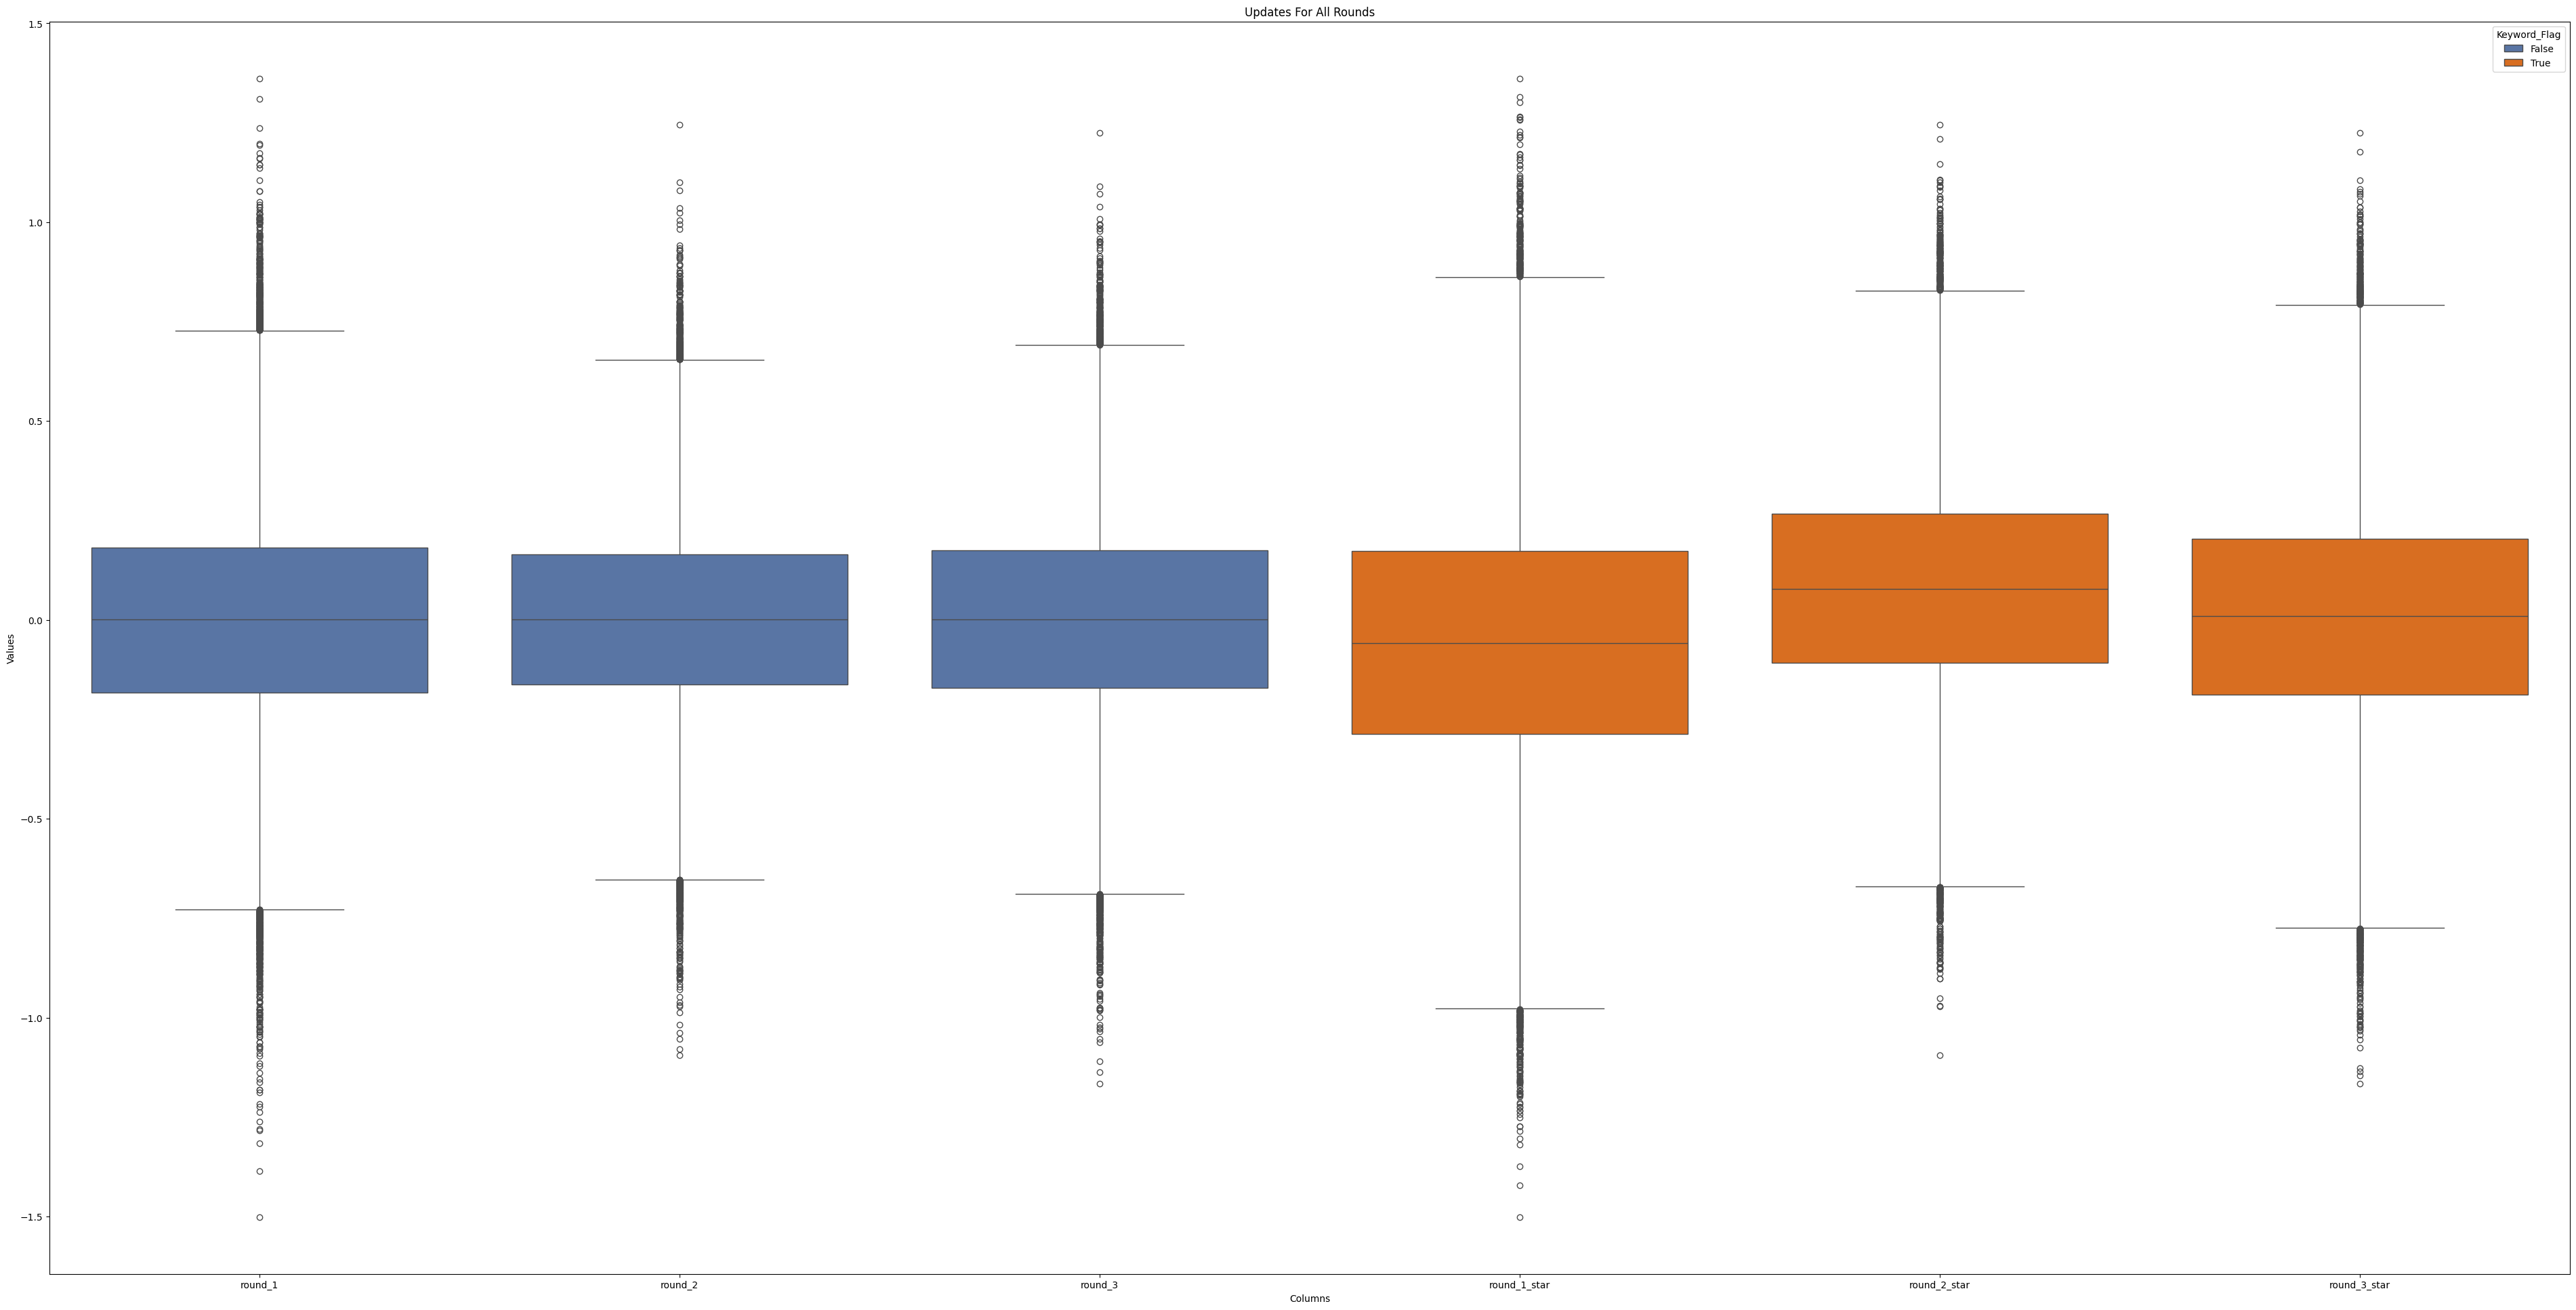

In [34]:
plt.figure(figsize=(48, 24))
sns.boxplot(x='Column', y='Value', hue='Keyword_Flag', data=df_melted_2, palette=palette)
plt.title('Updates For All Rounds')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()